# In this notebook, whole reconstruction pipeline without butter_filter  is illustrated
tdms(raw_data) --> ICA --> HOSD (higher-order spectral filtering)

without butter filtering, ICA almost takes twice as much time that of with butter filter
and it has no effect on higher order filtering.

In [1]:
import functions
import scipy
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter
from hosd_python.hosd import apply_hosd # library that I converted from MATLAB

In [2]:
no_ica_chans = 18
fs=1000
span = 10*fs
offset = 100*fs 
ms2s = lambda x, _:f'{x/1000:g}' 

In [3]:

data = functions.array_from_TDMSgroup("patients/P044/P044_S01_D2024-04-18_G36.tdms", "R001")
#filtered_data = functions.butter_filter(data)
filtered_data = data.copy()

In [4]:
components = functions.FASTICA(filtered_data[5000:, 1:], no_ica_chans)

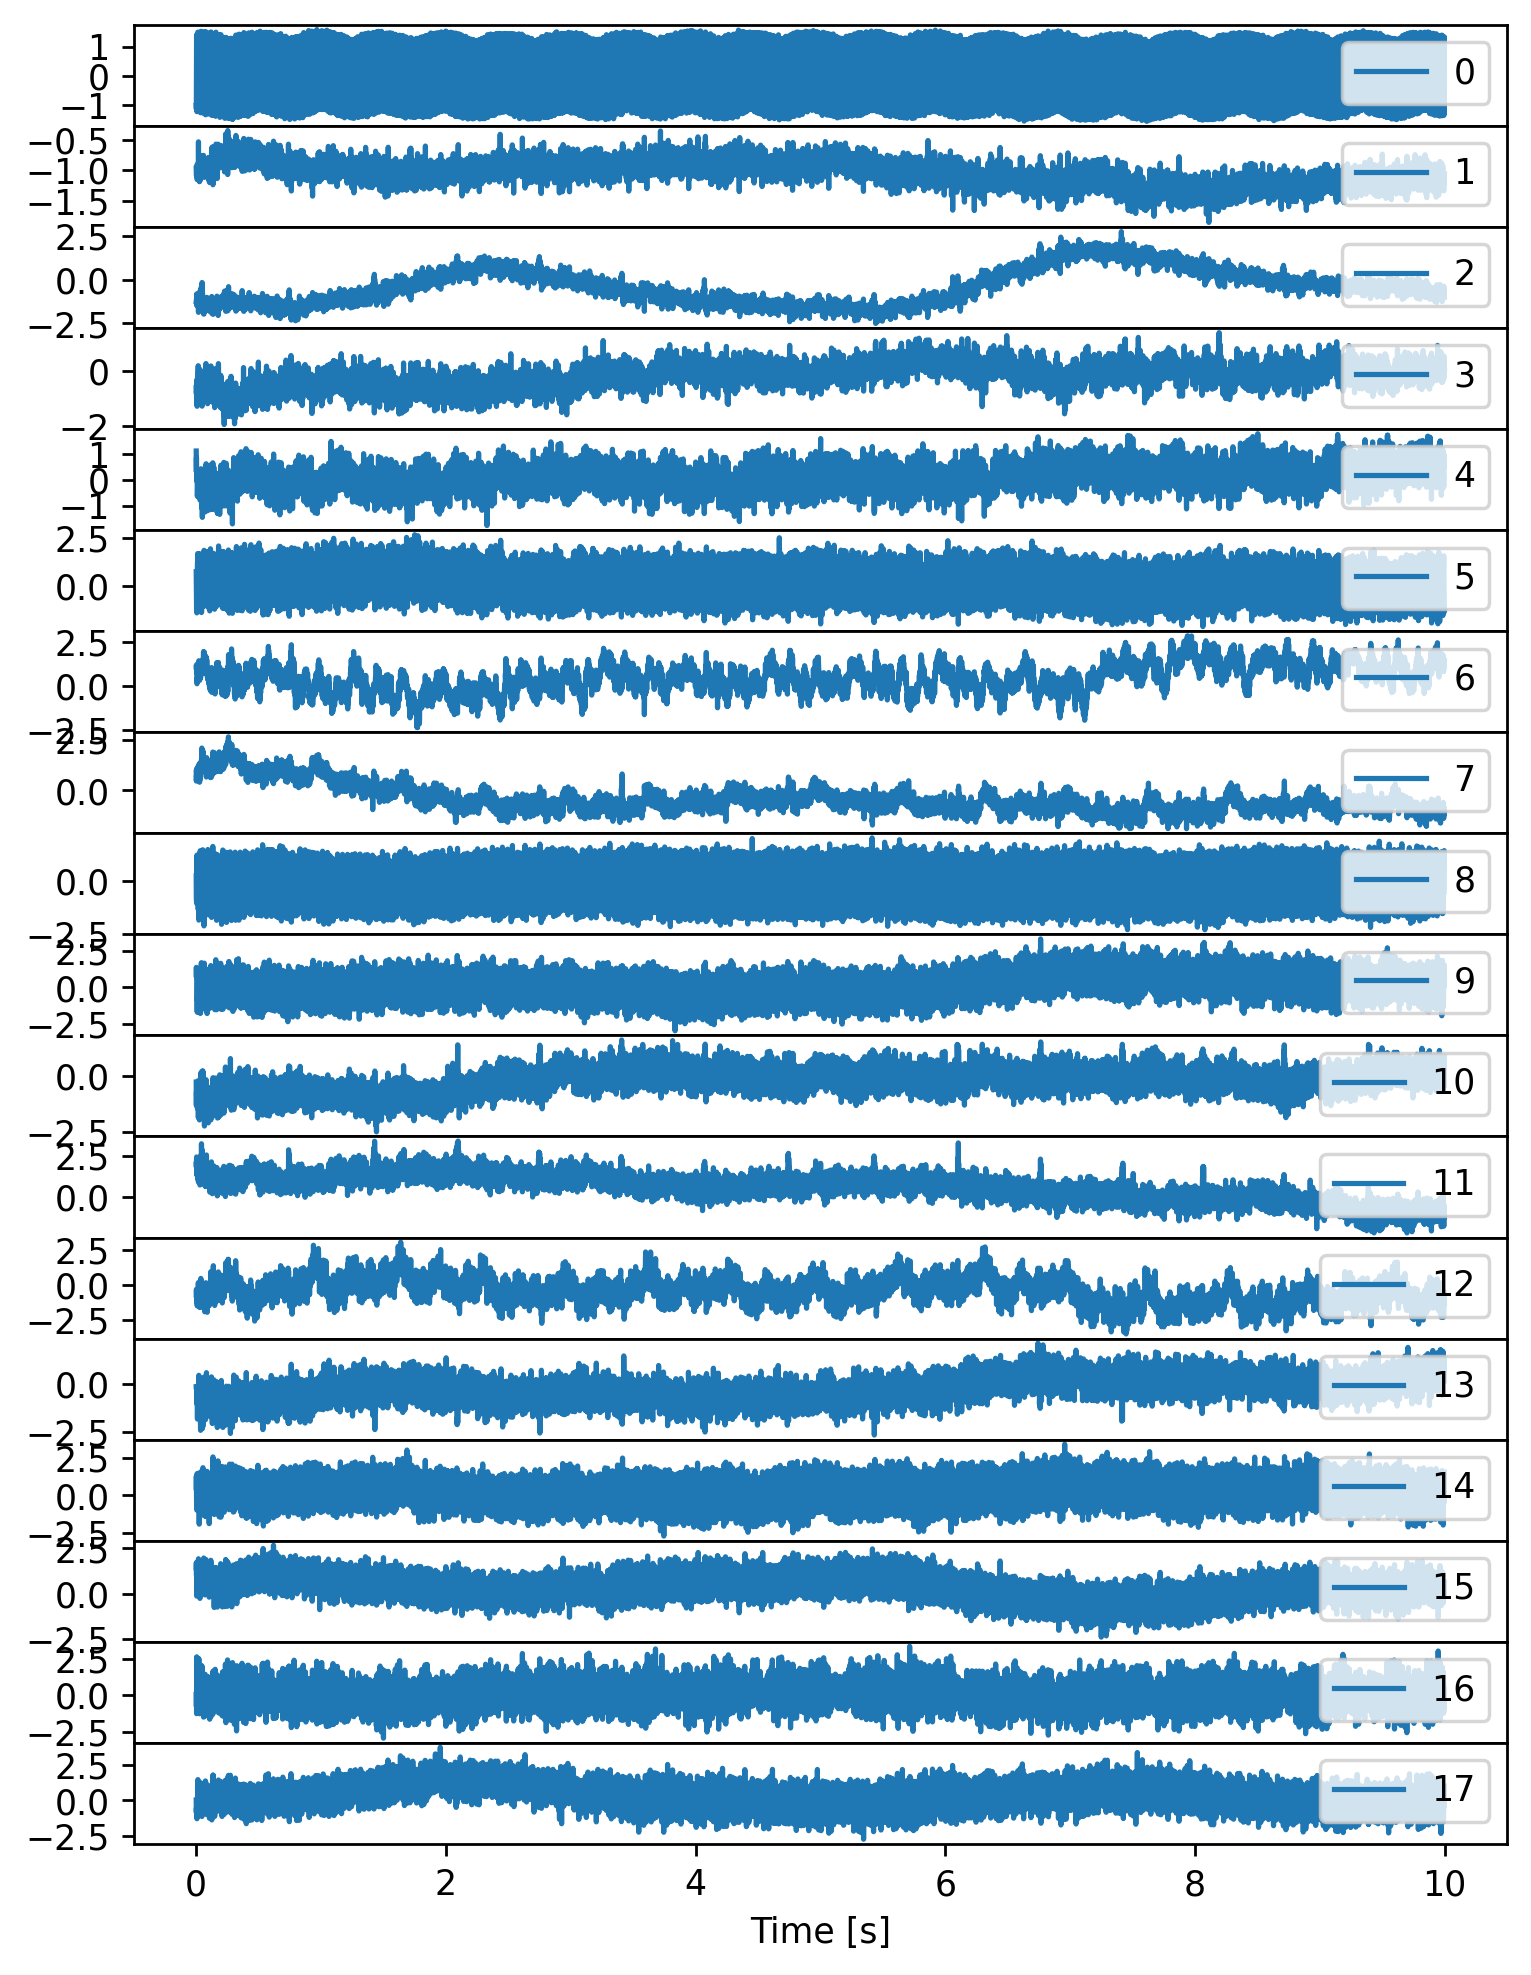

In [5]:
fig, ax = plt.subplots(no_ica_chans, 1, sharex=True, figsize=(18 / 2.54, 24 / 2.54), dpi=250) #
fig.subplots_adjust(hspace=0)
    
for j in range(no_ica_chans):
    ax[j].plot(components[offset:(offset + span), j], label=str(j))
    ax[j].legend(loc=1)
ax[-1].xaxis.set_major_formatter(ms2s)
ax[-1].set_xlabel('Time [s]')
plt.show()

### Without butter filter, identifying the independent components are much harder as we can see below

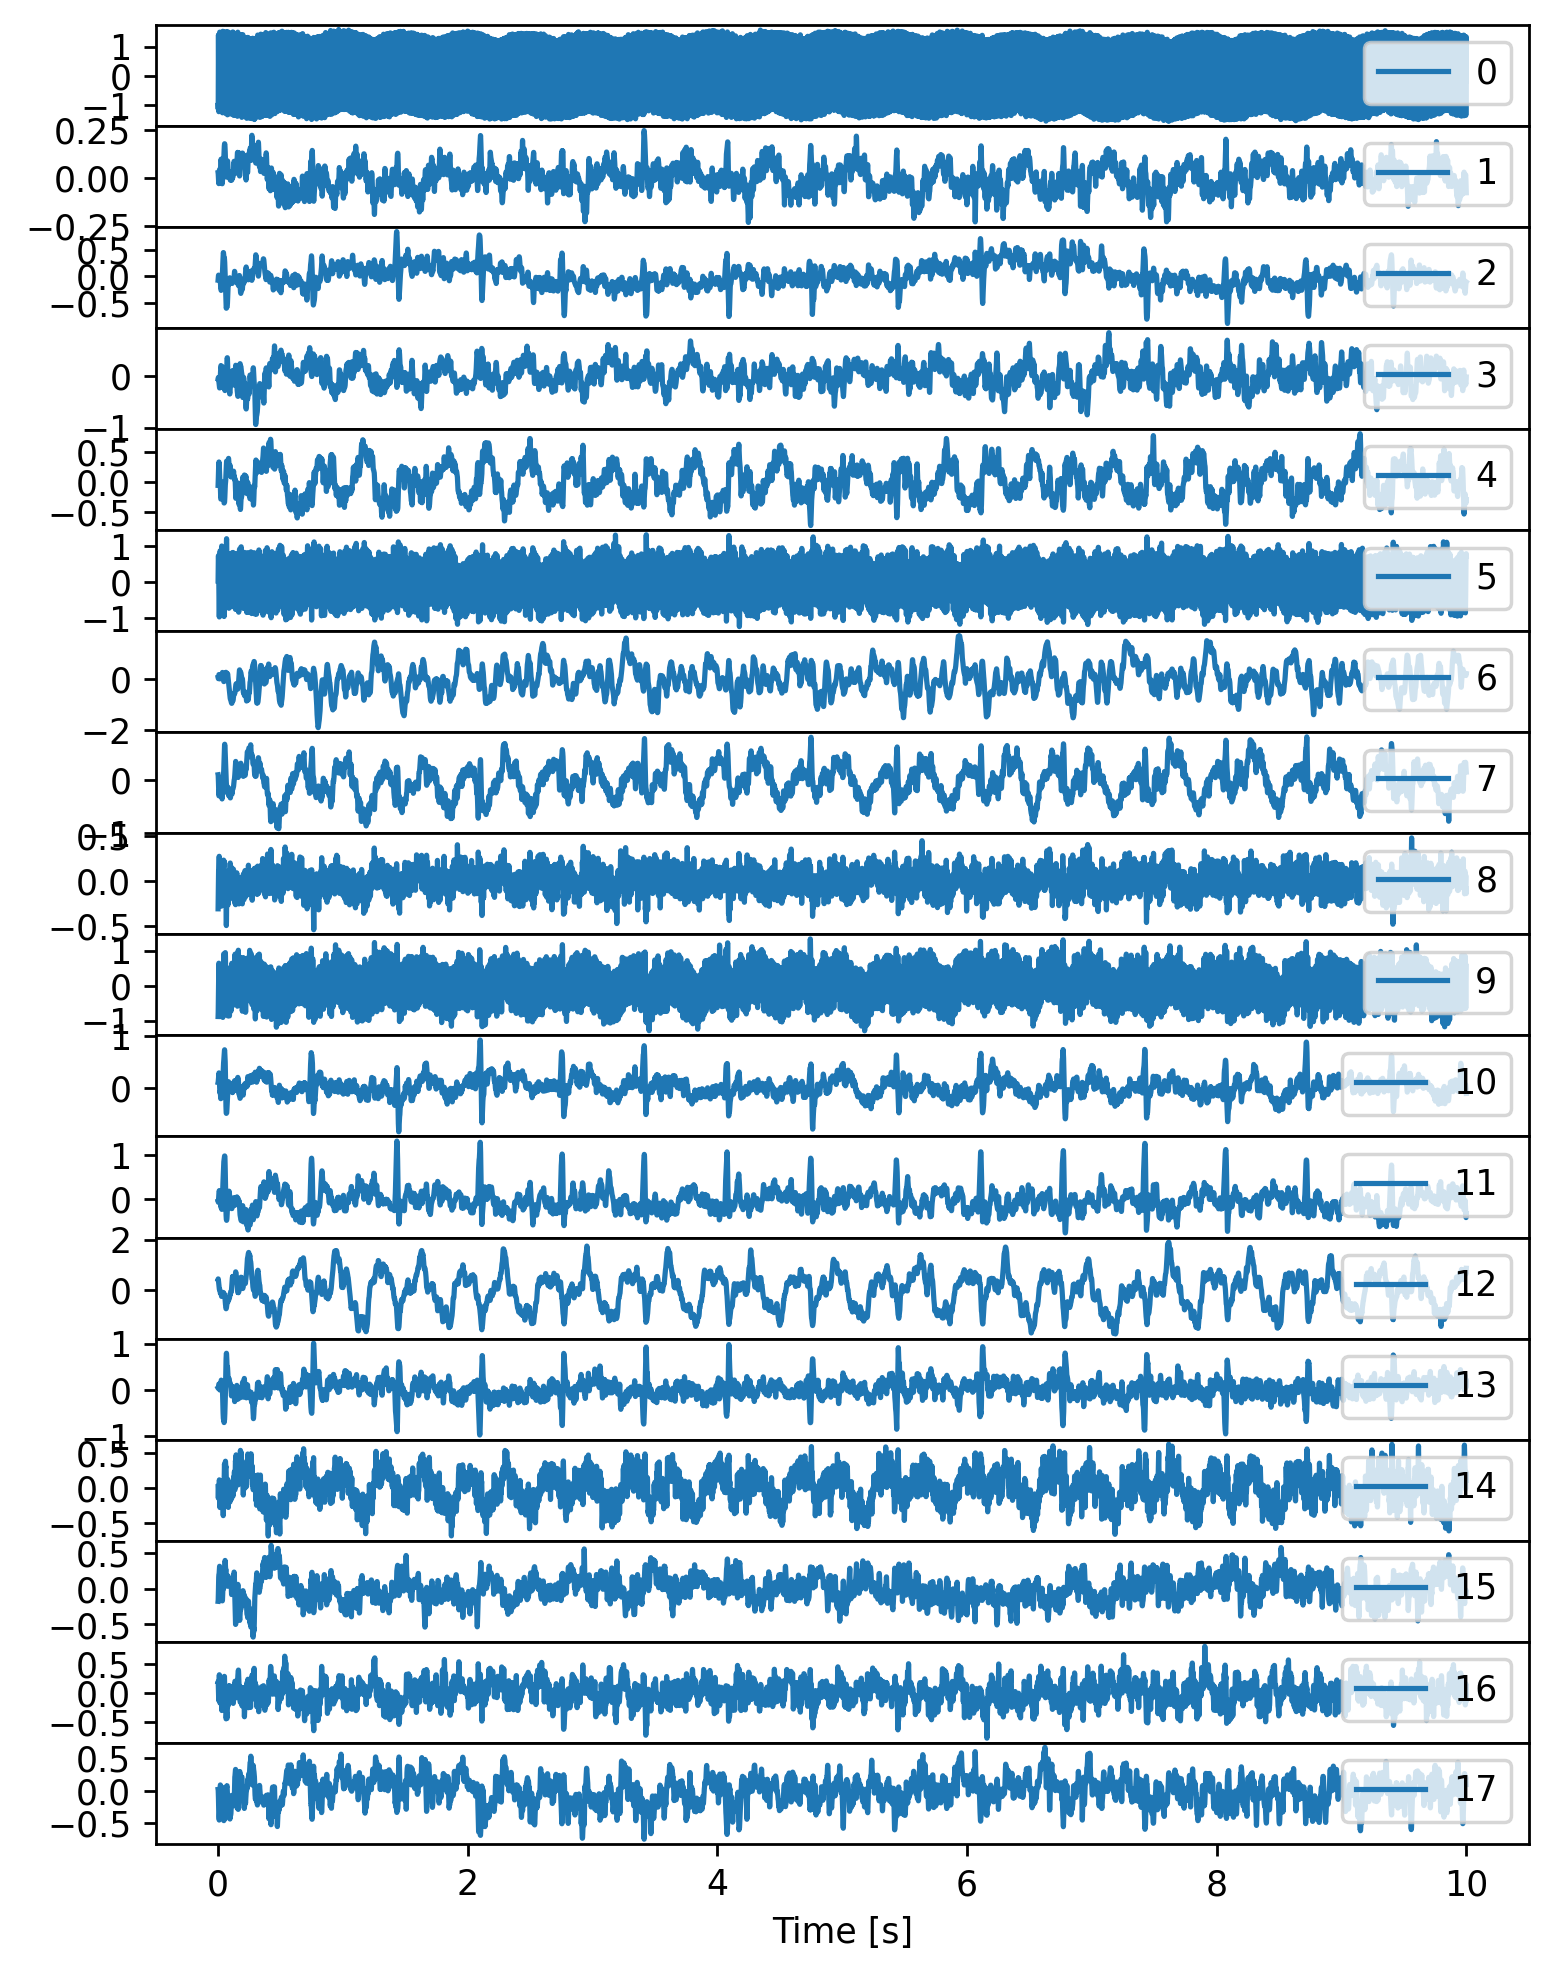

In [6]:
filtered_ICA = functions.butter_filter(components.copy())
fig, ax = plt.subplots(no_ica_chans, 1, sharex=True, figsize=(18 / 2.54, 24 / 2.54), dpi=250) #
fig.subplots_adjust(hspace=0)
    
for j in range(no_ica_chans):
    ax[j].plot(filtered_ICA[offset:(offset + span), j], label=str(j))
    ax[j].legend(loc=1)
ax[-1].xaxis.set_major_formatter(ms2s)
ax[-1].set_xlabel('Time [s]')
plt.show()

I just filtered, the ICA data to select the fetal and maternal components but then again, continued with the unfiltered version, but I couldn't find the correct fetal component, so the analysis does not work properly

but from frequency, I think it is 9

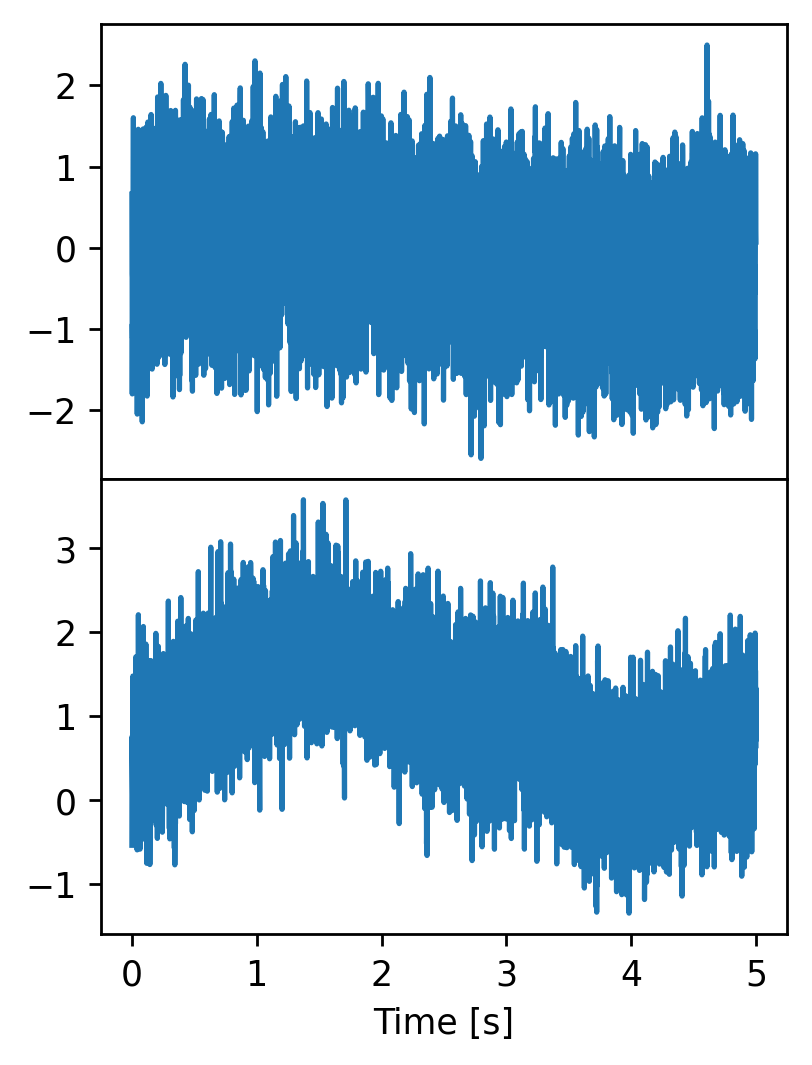

In [10]:
maternal_component = 13
fetal_component = 9

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(9 / 2.54, 12 / 2.54), dpi=250) #) #
fig.subplots_adjust(hspace=0)

ax[0].plot(components[:5000, fetal_component])
ax[1].plot(components[:5000, maternal_component],)
ax[-1].xaxis.set_major_formatter(ms2s)
ax[-1].set_xlabel('Time [s]')
plt.show()

To be able to detect diseases, we should be able to clearly identify the imporant points on the heart interval. Thus, we need this higher-order spectral filtering, which makes use of the phase information and find the best filter for it.

In [11]:
window_size=int(1400) # used for higher-order-spectral filtering
time_axis=np.linspace(0,int(window_size)-1,num=int(window_size))
beat, detect = apply_hosd(components[:,fetal_component], window_size) # give the fetus component data with window size

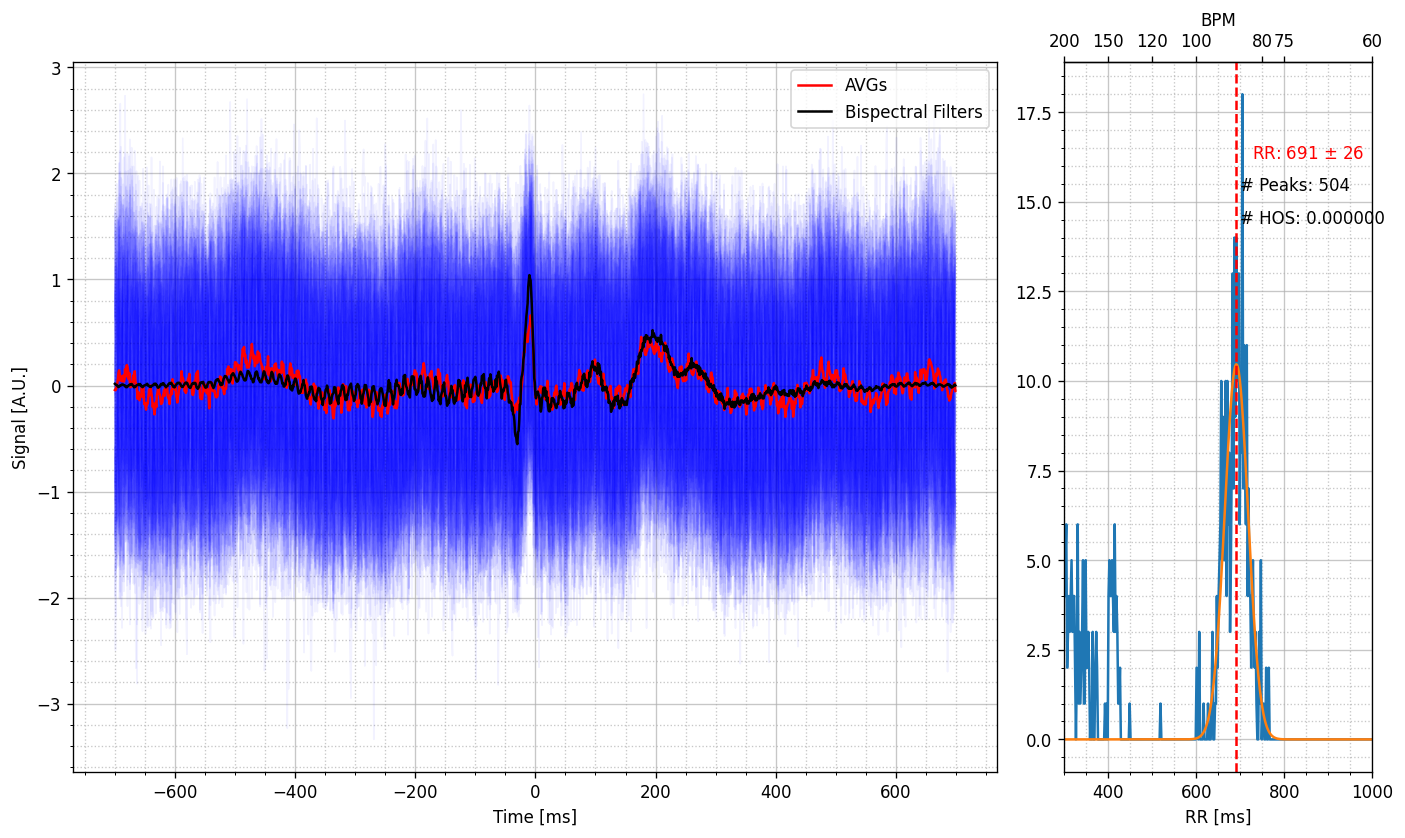

In [12]:
RR, sigma_RR, peaks, popt_RRs, yy, xx = functions.detect_beats(detect)
try:
    savgol_median = savgol_filter(np.diff(peaks), 41, 3)
    avg_peaks_list = peaks[np.where(np.square((np.diff(peaks) - savgol_median) / sigma_RR) < 2)]
except:
    avg_peaks_list = peaks

peaks = avg_peaks_list
if len(peaks)<3:
    print('skipped (low peak count)')
else:
    slice_box, avg_mean,worked = functions.avg_based_QRScomplex(components[:,fetal_component], peaks,sigma_RR, box_size=window_size)
    segmentation_data=functions.waveform_plot(np.array(slice_box), time_axis-window_size/2, add_lines=[avg_mean,beat], sideplot=[xx,yy,popt_RRs,RR,sigma_RR,0])